In [1]:
import torch
torch.set_grad_enabled(False)
import math
import matplotlib.pyplot as plt

In [2]:
from Activations import Tanh, ReLU
from Sequential import Sequential
from Linear import Linear
from Losses import LossMSE, LossCrossEntropy

In [3]:
# Unit test relu
torch.set_grad_enabled(True)

tol = 0.0001
D = 2
N=10
input = torch.empty(N,D).normal_().requires_grad_()
r1 = ReLU()
r2 = torch.nn.ReLU()

prediction1 = r1(input)
prediction2 = r2(input)

target = torch.empty(N,D).normal_().requires_grad_()

criterion2 = torch.nn.MSELoss()
criterion1 = LossMSE()
loss2 = criterion2(prediction2, target)
loss1 = criterion1(prediction1, target)

back = criterion1.backward(prediction1, target)


print(torch.autograd.grad(loss2,input))
print(r1.backward(back))
torch.set_grad_enabled(False)

(tensor([[ 0.0402,  0.1373],
        [ 0.0256,  0.0000],
        [-0.0058,  0.0000],
        [-0.0407,  0.1256],
        [ 0.0000,  0.1010],
        [ 0.0078,  0.0000],
        [ 0.1252,  0.0000],
        [ 0.0946,  0.1003],
        [ 0.0806,  0.1870],
        [ 0.0000,  0.0000]]),)
tensor([[ 0.0402,  0.1373],
        [ 0.0256,  0.0000],
        [-0.0058,  0.0000],
        [-0.0407,  0.1256],
        [ 0.0000,  0.1010],
        [ 0.0078,  0.0000],
        [ 0.1252,  0.0000],
        [ 0.0946,  0.1003],
        [ 0.0806,  0.1870],
        [ 0.0000,  0.0000]], grad_fn=<IndexPutBackward>)


In [4]:
# Unit test MSE loss
D = 5
N=18
tol = 0.0001
torch.set_grad_enabled(True)

input1 = torch.empty(N,D).normal_().requires_grad_()
target = torch.empty(N,D).normal_().requires_grad_()
l1 = torch.nn.MSELoss()
l2 = LossMSE()
a = l1(input1, target)
b = l2(input1, target)
assert((a-b).abs() < tol)
assert((torch.autograd.grad(a, input1)[0] - l2.backward(input1, target)).abs().max() < tol)
torch.set_grad_enabled(False)


In [5]:
# Unit test cross entropy
torch.set_grad_enabled(True)

criterion1 = torch.nn.CrossEntropyLoss()
criterion = LossCrossEntropy()
input = torch.tensor([[1.,10,1,2],[1,0,1.,2]]).requires_grad_()
target = torch.tensor([1,0])
b = criterion(input,target)
a = criterion1(input,target)
print(a)
print(b)

print()
print(torch.autograd.grad(a,input))
print()
print(criterion.backward(input, target))
torch.set_grad_enabled(False)


tensor(0.8136, grad_fn=<NllLossBackward>)
tensor(0.8136, grad_fn=<MulBackward0>)

(tensor([[ 6.1669e-05, -2.9093e-04,  6.1669e-05,  1.6763e-04],
        [-4.0169e-01,  3.6165e-02,  9.8306e-02,  2.6722e-01]]),)

tensor([[ 6.1669e-05, -2.9098e-04,  6.1669e-05,  1.6763e-04],
        [-4.0169e-01,  3.6165e-02,  9.8306e-02,  2.6722e-01]],
       grad_fn=<CopySlices>)


In [6]:
def accuracy(input, target):
    input = input.argmax(axis=1)
    accuracy = ((input-target) != 0).double()
    accuracy = (1-accuracy.mean()) * 100
    accuracy = accuracy.item()
    return accuracy

In [18]:
def f_score(input, target, alpha=0.5):
    """
    Computes the f-score measure between the input and target tensors.
    
    Args:
    input -- tensor of size (N, *)
    target -- tensor of size (N, 1)
    
    Returns:
    fscore -- the fscore between 0 and 1
    """
    N = target.size(0)
    input = input.argmax(axis=1)
    true_positive = ((target == 1) & (input == 1)).sum().item()
    true_negative = ((target == 0) & (input == 0)).sum().item()
    false_positive = ((target == 0) & (input == 1)).sum().item()
    false_negative = ((target == 1) & (input == 0)).sum().item()
    
    if ((true_positive + false_positive == 0) or 
        (true_positive + false_negative == 0) or 
        (true_positive == 0)):
        return 0
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    fscore = (1/(alpha*(1/precision) + (1-alpha)*(1/recall)))
    return round(fscore,3)

# First Test 

In [31]:
def generate_disk_data(nb_points = 1000, radius = 1/(math.sqrt(2*math.pi))):
    """
    Generates a training and a test set of "nb_points" points 
    sampled uniformly in [0, 1]^2 , each with a
    label, 0 if outside the disk of radius "radius" and 1 if inside.
    
    Args:
    nb_points -- the number of point to generate
    radius -- the radius of the disk
    
    Returns:
    X_train, y_train, X_test, y_test -- tensor containing the points 
    along with their labels
    """
    
    N = nb_points  
    X_train = torch.empty(N,2).uniform_(0,1)
    X_test = torch.empty(N,2).uniform_(0,1)
    
    y_train = ((X_train[:,0]**2 + X_train[:,1]**2) < radius**2).long()
    y_test = ((X_test[:,0]**2 + X_test[:,1]**2) < radius**2).long()
    return X_train, y_train, X_test, y_test

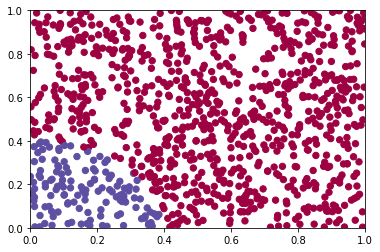

In [33]:
#generate disk data
X_train, y_train, X_test, y_test = generate_disk_data()

fig = plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [34]:
model = Sequential(Linear(2,25), ReLU(), Linear(25,25),ReLU(), Linear(25,25),ReLU(), Linear(25,2))
criterion = LossMSE()

In [35]:
#train model
epoch = 1000
for e in range(epoch):
    output = model(X_train)
    loss = criterion(output, y)
    if e%200 == 0:
        print("loss: {0}".format(loss))
    dloss = criterion.backward(output, y)
    model.backward(dloss)
    model.update_params(0.001)
    model.zero_grad()
    
output_train = model(X_train)
print("acc train" + str(accuracy(output_train,y_train)))
output_test = model(X_test)
print("acc test " + str(accuracy(output_test, y_test)))

print("f train " + str(f_score(output_train, y_train)))
print("f test " + str(f_score(output_test, y_test)))


loss: 1421.1793212890625
loss: 0.3520130217075348
loss: 0.2593555152416229
loss: 0.21809683740139008
loss: 0.19358211755752563
acc train85.0
acc test 84.5
f train 0.167
f test 0.153


In [36]:
model = Sequential(Linear(2,25), ReLU(), Linear(25,25),ReLU(), Linear(25,25),ReLU(), Linear(25,2))
criterion = LossCrossEntropy()

In [37]:
#train model
epoch = 1000
for e in range(epoch):
    output = model(X_train)
    loss = criterion(output, y_train)
    if e%100 == 0:
        print("loss: {0}".format(loss))
    dloss = criterion.backward(output, y_train)
    model.backward(dloss)
    model.update_params(0.001)
    model.zero_grad()
    
output_train = model(X_train)
print("acc train " + str(accuracy(output_train,y_train)))
output_test = model(X_test)
print("acc test " + str(accuracy(output_test, y_test)))

print("f train " + str(f_score(output_train, y_train)))
print("f test " + str(f_score(output_test, y_test)))


loss: inf
loss: 0.1501738280057907
loss: 0.04779758304357529
loss: 0.03392229229211807
loss: 0.029795052483677864
loss: 0.027607642114162445
loss: 0.026089271530508995
loss: 0.024871869012713432
loss: 0.0238417349755764
loss: 0.023011716082692146
acc train99.4
acc test 99.6
f train 0.977
f test 0.986


(0.001312255859375, 0.981312233954668)

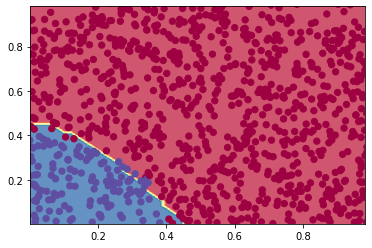

In [29]:
import numpy as np
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X_test[:, 0].min(), X_test[:, 0].max()
y_min, y_max = X_test[:, 1].min(), X_test[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

myX = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
Z = torch.tensor(np.zeros((myX.shape[0],2))).double()
Z = model.forward(myX)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)


fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train[0:1000, 0], X_train[0:1000, 1], c=y_train[0:1000], s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Little example with few layers

In [543]:
l1 = Linear(2,5)
l2 = Linear(5,10)
l3 = Linear(10,3)
r1 = ReLU()
r2 = ReLU()

In [544]:
model = Sequential(l1,r1, l2,r2, l3)
loss_module = LossMSE()

In [545]:
x = torch.empty(10,2).normal_()
real_w = torch.empty(3,2).normal_()
real_b = torch.empty(3).normal_()
y = x @ real_w.T + real_b

In [546]:
#train model
epoch = 1000
for e in range(epoch):
    output = model.forward(x)
    loss = loss_module.forward(output, y)
    if e%100 == 0:
        print("loss: {0}".format(loss))
    dloss = loss_module.backward(output, y)
    model.backward(dloss)
    model.update_params(0.001)
    model.zero_grad()

loss: 43.87044143676758
loss: 4.113137722015381
loss: 1.5851784944534302
loss: 1.1278547048568726
loss: 0.9454269409179688
loss: 0.8097853064537048
loss: 0.7099971771240234
loss: 0.625080943107605
loss: 0.5362294316291809
loss: 0.4763529896736145


# Little example with 1 linear Layer

In [540]:
linearLayer = Linear(2,3, bias=True)
loss_module = LossMSE()

#generate data
x = torch.empty(10,2).normal_()
real_w = torch.empty(3,2).normal_()
real_b = torch.empty(3).normal_()
y = x @ real_w.T + real_b
print(real_w)
print(real_b)

tensor([[ 0.2477,  0.5727],
        [ 1.3505,  0.2516],
        [ 0.8788, -0.3805]])
tensor([ 1.5689, -0.2951, -1.4344])


In [541]:
#train model
epoch = 1000
for e in range(epoch):
    output = linearLayer.forward(x)
    loss = loss_module.forward(output, y)
    if e%100 == 0:
        print("weight: {0}".format(linearLayer.weight))
        print("bias: {0}".format(linearLayer.bias))
        print("loss: {0}".format(loss))
    dloss = loss_module.backward(output, y)
    linearLayer.backward(dloss)
    linearLayer.update_params(0.1)
    linearLayer.zero_grad()

weight: tensor([[-0.2542, -0.6756],
        [ 0.3761, -0.8413],
        [-2.0694,  2.1834]])
bias: tensor([0.4356, 0.9977, 1.0921])
loss: 8.920021057128906
weight: tensor([[ 0.1345,  0.3111],
        [ 1.1387, -0.2325],
        [ 0.9162, -0.2844]])
bias: tensor([ 1.6611, -0.1228, -1.4651])
loss: 0.023080212995409966
weight: tensor([[ 0.2110,  0.4885],
        [ 1.2824,  0.0953],
        [ 0.8920, -0.3503]])
bias: tensor([ 1.5988, -0.2397, -1.4452])
loss: 0.0024013265501707792
weight: tensor([[ 0.2358,  0.5455],
        [ 1.3285,  0.2012],
        [ 0.8831, -0.3707]])
bias: tensor([ 1.5786, -0.2772, -1.4379])
loss: 0.0002499320835340768
weight: tensor([[ 0.2439,  0.5639],
        [ 1.3434,  0.2353],
        [ 0.8802, -0.3773]])
bias: tensor([ 1.5721, -0.2893, -1.4356])
loss: 2.601312371552922e-05
weight: tensor([[ 0.2465,  0.5699],
        [ 1.3482,  0.2463],
        [ 0.8792, -0.3795]])
bias: tensor([ 1.5700, -0.2932, -1.4348])
loss: 2.7075309390056645e-06
weight: tensor([[ 0.2473,  0.

In [542]:
print(real_w)
print(real_b)

tensor([[ 0.2477,  0.5727],
        [ 1.3505,  0.2516],
        [ 0.8788, -0.3805]])
tensor([ 1.5689, -0.2951, -1.4344])
